In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import invgamma
import scipy.integrate as integrate
import scipy.optimize as opt
import emcee
import corner
import matplotlib
font = {'size'   : 14}

matplotlib.rc('font', **font)

In [2]:
# read the supernova (cosmological) redshift data
datafile = open('SCPUnion2.1_mu_vs_z.txt','r')
SCP_data = pd.read_table(datafile,comment='#',
                        names=['SN name','Redshift','Distance modulus',
                                   'Distance modulus error','P low mass'])
print(SCP_data)

    SN name  Redshift  Distance modulus  Distance modulus error  P low mass
0    1993ah  0.028488         35.346583                0.223906    0.128419
1    1993ag  0.050043         36.682368                0.166829    0.128419
2     1993o  0.052926         36.817691                0.155756    0.128419
3     1993b  0.070086         37.446737                0.158467    0.128419
4    1992bs  0.062668         37.483409                0.156099    0.128419
..      ...       ...               ...                     ...         ...
575   D-000  1.017000         44.293971                0.171046    0.000015
576   D-006  1.315000         44.971358                0.187509    0.551672
577   P-009  0.821000         43.640939                0.194014    0.551672
578   R-012  1.215000         45.246521                0.560317    0.000148
579   Z-005  0.623000         42.514524                0.241428    0.551672

[580 rows x 5 columns]


In [3]:
filename = 'SCPUnion2.1_mu_vs_z.txt'

# Load the data from the file
data = np.loadtxt(filename, usecols=(1, 2, 3, 4), skiprows = 5)
Nd = 580
c = 299792.458 # km/s
alpha = 0.121851859725
beta = 2.46569277393

z = data[:, 0] # size: 580x1
mu = data[:, 1]
mu_error = data[:, 2]
P_low_mass = data[:, 3]
dl = 10**(mu/5-5)
dl_error = 10**(mu/5-5)*(10**(mu_error/5) - 1)

low = z < 0.5

low_z = z[low] # size: 412x1
low_mu = mu[low]
low_mu_error = mu_error[low]
low_P_low_mass = P_low_mass[low]
low_dl = 10**(low_mu/5-5)
low_dl_error = dl_error[low]

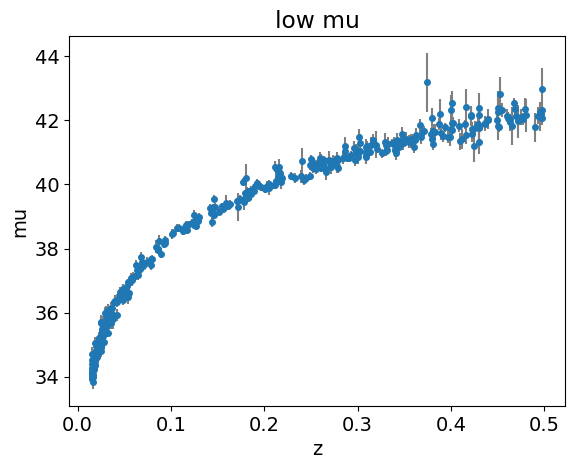

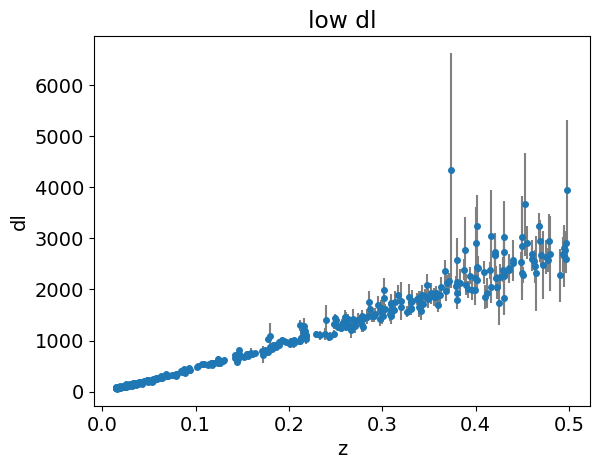

In [4]:
plt.figure(1)
plt.errorbar(low_z, low_mu, yerr=low_mu_error, fmt='o', ecolor='gray', linestyle='None', markersize=4)
plt.xlabel('z')
plt.ylabel('mu')
plt.title('low mu')

plt.show()

plt.figure(2)
plt.errorbar(low_z, low_dl, yerr=low_dl_error, fmt='o', ecolor='gray', linestyle='None', markersize=4)
plt.xlabel('z')
plt.ylabel('dl')
plt.title('low dl')

plt.show()

In [5]:
# Task 1

In [6]:
# Normalized weights.
W = np.square(1/low_dl_error)
Nw = np.sum(W)/412
W = W/Nw

In [7]:
def dl_model(z, H0, q0):
    return c / H0 * (z + 0.5 * (1-q0) * z**2)

In [8]:
def log_likelihood(param, z, dl, W):
    H0, q0, sig2 = param
    n = len(dl)
    return -0.5 * (np.sum((dl - dl_model(z, H0, q0))**2 * W / sig2)) - (n/2) * np.log(2 * np.pi * sig2)

def log_prior(sig2):
    if sig2 > 1e-16:
        return invgamma.logpdf(sig2, a = alpha, scale = beta) 
    else:
        return -np.inf

def log_posterior(param, z, dl, W):
    lp = log_prior(param[-1])
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(param, z, dl, W)
    return ll + lp

In [9]:
def simple_mcmc_analysis(sampler, pars, labels, burn_in, title):

    print(f'Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):0.3f}')
    # discard the first 'burn_in' samples 
    
    # thinning means that you only keep every nth sample. E.g. thinning=10 -> keep every 10th sample.
    # This can be useful for reducing long autocorrelation lenghts in a chain. However, thinning is expensive.
    # A thinned chain must be run E.g. 10x longer to reach the desired number of samples.
    # One can argue that thinning is not an advantageous strategy. So keep thinning = 1
    thinning = 1
    flat_mcmc_samples = sampler.get_chain(discard=burn_in,thin=thinning, flat=True)
    print(f'Discarding {nwalkers*burn_in} steps as burn-in')
    print(f'Chain length:{len(flat_mcmc_samples)}')
    fig1 = plt.figure();
    for par in pars:
        mean = np.sum(flat_mcmc_samples[:5000,par]) / len(flat_mcmc_samples[:5000,par])
        sub_mean = flat_mcmc_samples[:5000,par]-mean 
        if max(sub_mean) > abs(min(sub_mean)):
            plt.plot(sub_mean/(2*max(sub_mean)),alpha=0.5, label = labels[par])
        else: 
            plt.plot(sub_mean/(-2*min(sub_mean)),alpha=0.5, label = labels[par])
    plt.xlabel('Sample');
    plt.ylabel("Normalized parameter value")
    plt.title(title)
    plt.legend()
    #plt.xlim(0,len(flat_mcmc_samples));
    #plt.savefig(f"{label}_trace.png")
    return flat_mcmc_samples

In [11]:
ndim, nwalkers = 3, 50
start_pos = [70, -0.4, 200] + 1 * np.random.randn(nwalkers, ndim)

sampler_1 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(low_z, low_dl, W))
sampler_1.run_mcmc(start_pos, 10000, progress=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:08<00:00, 113.20it/s]


State([[ 70.06110994  -0.41608938 168.56311026]
 [ 70.24980377  -0.44772972 189.5568925 ]
 [ 70.08549149  -0.34951279 162.76119874]
 [ 69.7592497   -0.39278281 179.00858449]
 [ 70.2902235   -0.40306464 179.32367478]
 [ 70.27854174  -0.39743986 195.43822373]
 [ 69.88919074  -0.39238328 160.19786763]
 [ 70.21542566  -0.43767092 167.51276008]
 [ 70.19051783  -0.3323627  182.68331748]
 [ 70.87465819  -0.43816299 173.43803402]
 [ 70.29308354  -0.39855672 187.952739  ]
 [ 70.63906297  -0.42390555 171.41479071]
 [ 70.3028737   -0.40338763 187.65405436]
 [ 70.20231757  -0.41783799 185.9400251 ]
 [ 70.46390908  -0.46301162 199.03100008]
 [ 70.12991676  -0.38500226 159.90915255]
 [ 69.80356114  -0.35299371 180.5437171 ]
 [ 70.29437791  -0.43688482 190.23051492]
 [ 70.38844141  -0.50055418 163.64542842]
 [ 70.32793142  -0.42538989 173.02091598]
 [ 70.23651566  -0.33501353 170.28815351]
 [ 70.35967418  -0.40928792 182.42497677]
 [ 69.69503075  -0.32649315 164.52852159]
 [ 69.55534161  -0.30415657 

Mean acceptance fraction: 0.642
Discarding 3000 steps as burn-in
Chain length:47000


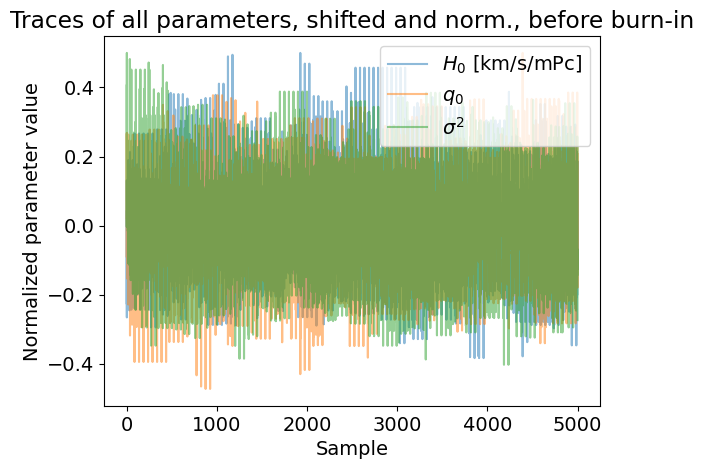

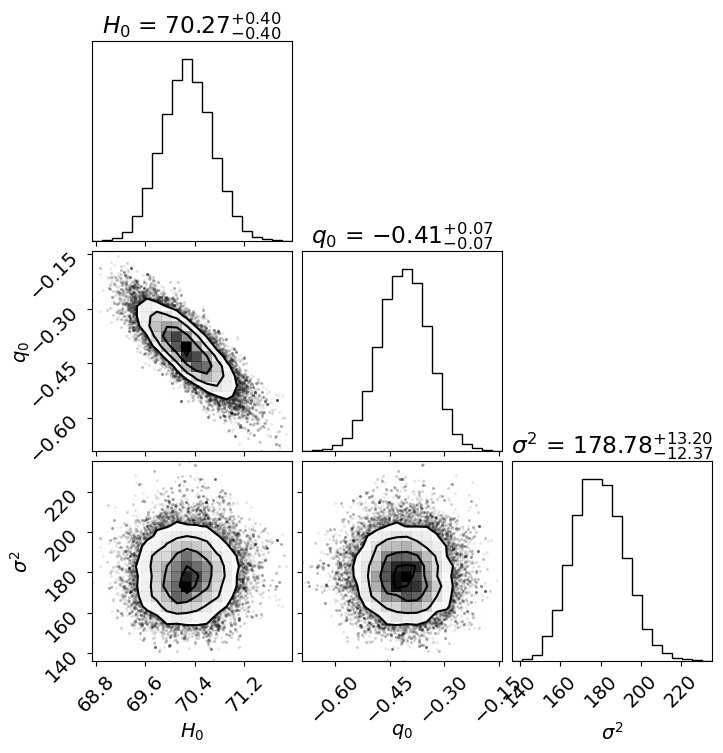

In [12]:
flat_mcmc_samples = simple_mcmc_analysis(sampler_1, [0,1,2], labels=[f'$H_0$ [km/s/mPc]', f"$q_0$", f"$\sigma^2$"], burn_in=60,title = f"Traces of all parameters, shifted and norm., before burn-in")
#flat_mcmc_samples = simple_mcmc_analysis(sampler, par=1, label=f'$q_0$', burn_in=60)
#flat_mcmc_samples = simple_mcmc_analysis(sampler, par=2, label=f'$\sigma^2$', burn_in=60)

fig = corner.corner(flat_mcmc_samples,labels=[r"$H_0$", r"$q_0$", r"$\sigma^2$"],show_titles=True, bins=20)
#plt.savefig('corner_plot.png')

C:\Users\Elsa3\AppData\Local\Temp\ipykernel_19664\2708528252.py:6: RuntimeWarning: invalid value encountered in scalar divide
  mean = np.sum(samples)/n_samples
C:\Users\Elsa3\AppData\Local\Temp\ipykernel_19664\2708528252.py:11: RuntimeWarning: invalid value encountered in scalar divide
  c_hat[t] = np.sum(vector[:]*vector[:])/(n_samples)


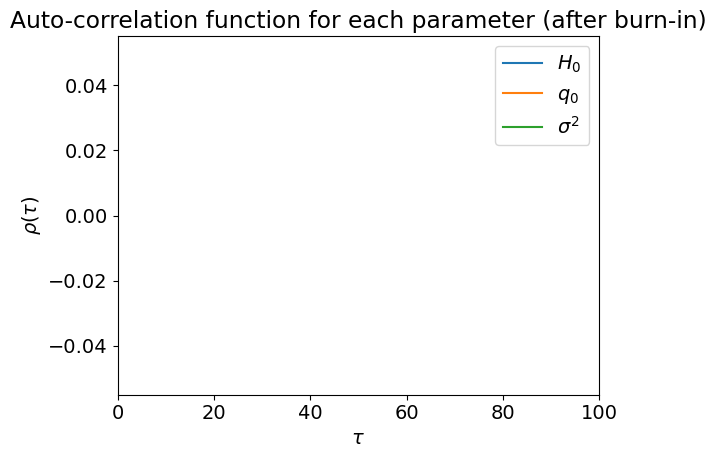

In [13]:
#Find autocorrelation function
tau = np.arange(0,1000)
samples_1 = sampler_1.chain[:, 3000:, :]
n_samples = len(samples_1[0,:,0])
def auto_corr(samples):
    mean = np.sum(samples)/n_samples
    vector = samples - mean
    c_hat = np.empty(len(tau)+1)
    for t in tau:
        if t == 0:
            c_hat[t] = np.sum(vector[:]*vector[:])/(n_samples)    
        #print((vector[:-t]*vector[t:]).shape)
        #if t != 100:
        #print(vector[:-t].shape)
        #print(vector[t:].shape)
        else:
            c_hat[t] = np.sum(vector[:-t]*vector[t:])/(n_samples-t)
    return c_hat[:-1]
auto_corr_H0 = auto_corr(samples_1[0,:,0])
auto_corr_q0 = auto_corr(samples_1[0,:,1])
auto_corr_sigma = auto_corr(samples_1[0,:,2])

for w in range(1,nwalkers):
    auto_corr_H0 += auto_corr(samples_1[w,:,0])
    auto_corr_q0 += auto_corr(samples_1[w,:,1])
    auto_corr_sigma += auto_corr(samples_1[w,:,2])

tau_plot = tau
plt.figure()
plt.plot(tau_plot, auto_corr_H0/max(auto_corr_H0), label = f"$H_0$")
plt.plot(tau_plot, auto_corr_q0/max(auto_corr_q0), label = f"$q_0$")
plt.plot(tau_plot, auto_corr_sigma/max(auto_corr_sigma), label = f"$\sigma^2$")
plt.xlim(0,100)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\rho(\tau)$")
plt.legend()
plt.title("Auto-correlation function for each parameter (after burn-in)")
plt.tight_layout()
plt.show()

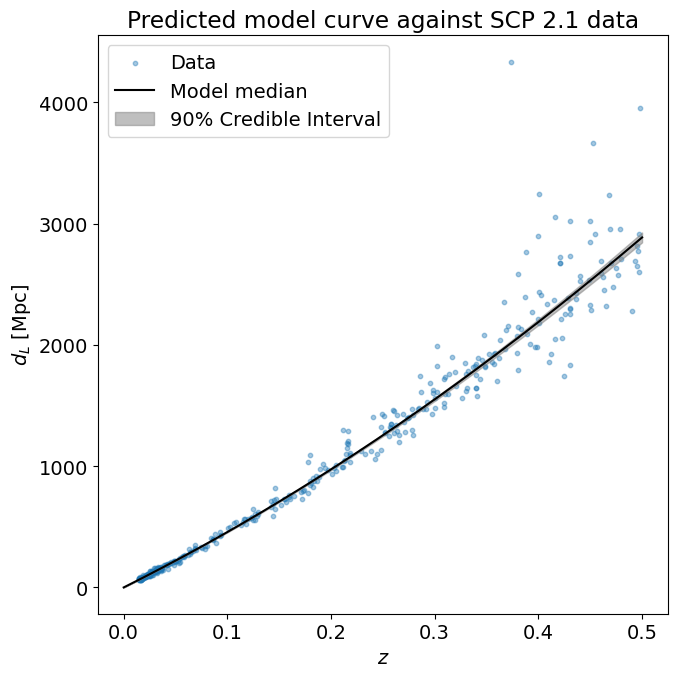

In [14]:
z_values = np.linspace(0, 0.5, 500)
#z_cherry = low_z[low_dl < 3500]
#dl_cherry = low_dl[low_dl < 3500]

samples = flat_mcmc_samples[:, :2]

# Calculate dl_model values for each sample
dl_samples = np.array([dl_model(z_values, *params) for params in samples])

# Calculate percentiles for the credible interval
lower_bound = np.percentile(dl_samples, 5, axis=0)
upper_bound = np.percentile(dl_samples, 95, axis=0)
median_dl = np.median(dl_samples, axis=0)

# Plotting
plt.figure(3, figsize = (7,7))
plt.scatter(low_z, low_dl, s=10, alpha=0.4, label='Data')
plt.plot(z_values, median_dl, color='black',label='Model median')
plt.fill_between(z_values, lower_bound, upper_bound, color='gray', alpha=0.5, label='90% Credible Interval')
plt.xlabel('$z$')
plt.ylabel('$d_L$ [Mpc]')
plt.legend()
plt.title("Predicted model curve against SCP 2.1 data")
plt.tight_layout()
plt.savefig('PPD.png')
plt.show()

H_0: 70.27195006018532


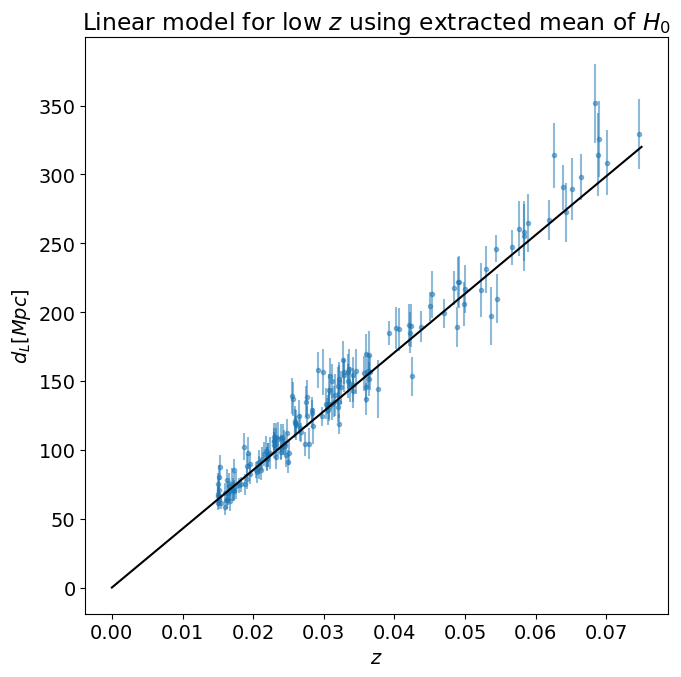

In [15]:
# Check av H0. För z > 0.075 är anpassningen sämre. Endast en term i utvecklingen av dl är här medtagen.

# Medelvärden.
H0_mean, q0_mean, sig2_mean = np.array([np.mean(flat_mcmc_samples[:,k]) for k in range(0,len(flat_mcmc_samples[0]))])
lower_z = low_z[low_z < 0.075]
lower_dl = low_dl[low_z < 0.075]
lower_dl_error = low_dl_error[low_z < 0.075]
z_lower_lin = np.linspace(0, 0.075, 500)

plt.figure(4, figsize=(7,7))
#plt.scatter(lower_z, lower_dl, s=10)
plt.errorbar(lower_z, lower_dl, yerr = lower_dl_error, barsabove=True, fmt='.', alpha = 0.5)
plt.xlabel('$z$')
plt.ylabel('$d_L [Mpc]$')
plt.plot(z_lower_lin, z_lower_lin*c/H0_mean, color='black')
plt.title(r"Linear model for low $z$ using extracted mean of $H_0$")
plt.tight_layout()

plt.savefig("linear_PPD.png")

print(f"H_0: {H0_mean}")


In [16]:
# Task 2

In [17]:
sorted_indices = np.argsort(z)
sorted_z = z[sorted_indices]
sorted_dl = dl[sorted_indices]

c = 299792.458
H0 = 70

In [18]:
# LCDM and wCDM models.
def E_wCDM(z, Omega_M0, w):
    return Omega_M0*(1+z)**3 + (1-Omega_M0)*(1+z)**(3*(1+w))

def E_LCDM(z, Omega_M0, w):
    return Omega_M0*(1+z)**3 + (1-Omega_M0)

# Eq 15.
def dl_model_full(E, z, Omega_M, w=None):
    dl_values = np.zeros_like(z)
    for i, z_i in enumerate(z):
        integral, _ = integrate.quad(lambda z: 1 / np.sqrt(E(z, Omega_M, w)), 0, z_i)
        dl_values[i] = c * (1 + z_i) / H0 * integral

    return dl_values

In [19]:
def log_likelihood(params, model, z, dl, dl_error):
    if model == 'LCDM':
        Omega_M0 = params[0]
        model = dl_model_full(E_LCDM, z, Omega_M0)
    elif model == 'wCDM':
        Omega_M0, w = params
        model = dl_model_full(E_wCDM, z, Omega_M0, w)

    w = 1 / dl_error**2
    w = len(dl_error)*w/sum(w)
    n = len(dl)
    return -0.5 * np.sum((dl - model) ** 2 * w) #+ (n/2)*np.log(2*np.pi*np.sum(dl_error**2))

neg_log_likelihood = lambda *args: -log_likelihood(*args)

In [20]:
# Optimum ΛCDM Model
initial_guess_LCDM = [0.3]  # Initial guess for Omega_M
result_LCDM = opt.minimize(neg_log_likelihood, initial_guess_LCDM, args=('LCDM', z, dl, dl_error))

# Optimum wCDM Model
initial_guess_wCDM = [0.3, -1]  # Initial guesses for Omega_M and w
result_wCDM = opt.minimize(neg_log_likelihood, initial_guess_wCDM, args=('wCDM', z, dl, dl_error))

In [21]:
# BIC and AIC scores. Minus the def. in the lecture notes.
aic_lcdm = -(2 * len(initial_guess_LCDM) + 2 * (-result_LCDM.fun))
bic_lcdm = -(len(initial_guess_LCDM) * np.log(len(z)) + 2 * (-result_LCDM.fun))

aic_wcdm = -(2 * len(initial_guess_wCDM) + 2 * (-result_wCDM.fun))
bic_wcdm = -(len(initial_guess_wCDM) * np.log(len(z)) + 2 * (-result_wCDM.fun))

diff_aic = aic_lcdm-aic_wcdm
diff_bic = bic_lcdm-bic_wcdm
diff_omega = result_LCDM.x - result_wCDM.x[0]
# Results
print(f"AIC for ΛCDM: {aic_lcdm}, BIC for ΛCDM: {bic_lcdm}")
print(f"AIC for wCDM: {aic_wcdm}, BIC for wCDM: {bic_wcdm}")
print(f"Diff AIC = {diff_aic}, Diff BIC = {diff_bic}")
print(f"Omega_M0 from ΛCDM: {result_LCDM.x}")
print(f"Omega_M0 and w from wCDM: {result_wCDM.x}")
print(f"Difference in Omega_M0: {diff_omega}")

AIC for ΛCDM: 147807.95324351132, BIC for ΛCDM: 147803.59021540778
AIC for wCDM: 147751.24079946388, BIC for wCDM: 147742.5147432568
Diff AIC = 56.71244404744357, Diff BIC = 61.07547215098748
Omega_M0 from ΛCDM: [0.31339473]
Omega_M0 and w from wCDM: [ 0.28200731 -0.92979606]
Difference in Omega_M0: [0.03138742]


In [22]:
def log_prior(Omega_M0):
    if 0.0 <= Omega_M0 <= 1.0:
        return 0.0 
    return -np.inf

def log_posterior(Omega_M0, z, dl, dl_error):
    prior = log_prior(Omega_M0)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_likelihood(Omega_M0, 'LCDM', z, dl, dl_error)

In [23]:
# MCMC of Omega_M0 of LCDM. Long runtime. Adjust nwalker and nsteps as you like.

ndim = 1
nwalkers = 20
burn_in = 1000
initial = np.random.rand(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z, dl, dl_error))

nsteps = 2000
sampler.run_mcmc(initial, nsteps, progress=True)

samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))  # Discard first 200 steps as burn-in

100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Mean acceptance fraction: 0.657
Discarding 0 steps as burn-in
Chain length:2000


C:\Users\Elsa3\AppData\Local\Temp\ipykernel_19664\2708528252.py:17: RuntimeWarning: invalid value encountered in scalar divide
  c_hat[t] = np.sum(vector[:-t]*vector[t:])/(n_samples-t)


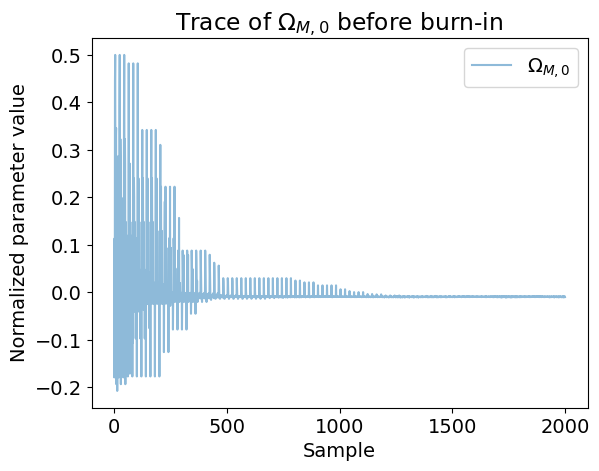

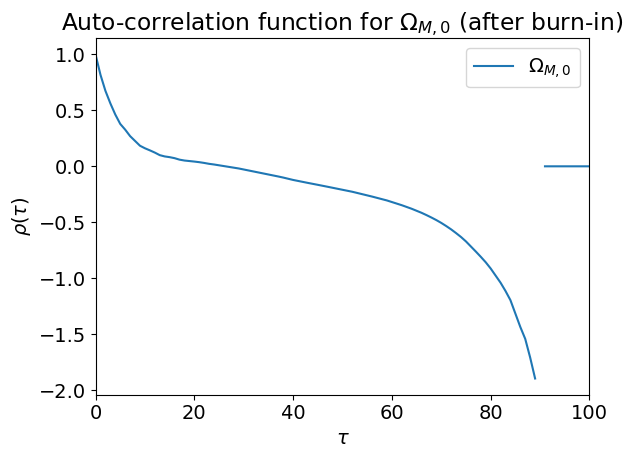

In [26]:
ndim = 1
nwalkers = 20
burn_in = 1000

samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))  # Discard first 200 steps as burn-in

flat_mcmc_samples = simple_mcmc_analysis(sampler, [0], labels=['$\Omega_{M,0}$'], burn_in=0, title = "Trace of $\Omega_{M,0}$ before burn-in")
#Find autocorrelation function
tau = np.arange(0,1000)
walker_samples = sampler.chain[:,burn_in:,:]
n_samples = len(walker_samples[0,:,0])
auto_corr_omega = auto_corr(walker_samples[0,:,0])
for w in range(1,nwalkers):
    auto_corr_omega += auto_corr(walker_samples[w,:,0])

tau_plot = tau
plt.figure()
plt.plot(tau_plot, auto_corr_omega/max(auto_corr_omega), label = "$\Omega_{M,0}$")
plt.xlim(0,100)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\rho(\tau)$")
plt.legend()
plt.title("Auto-correlation function for $\Omega_{M,0}$ (after burn-in)")
plt.tight_layout()
plt.show()

0.027717407340801775


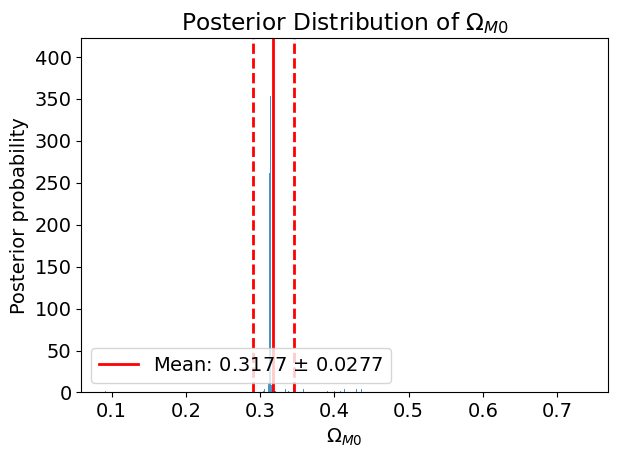

Mean Omega_M0: 0.31771552332142167


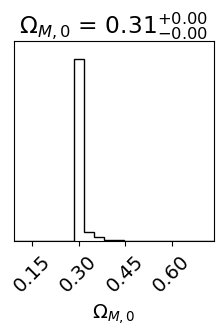

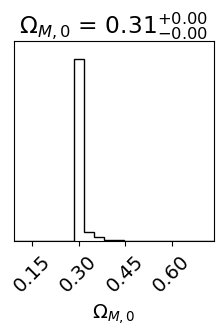

In [27]:
mean_Omega_M0 = np.mean(samples[:, 0])
median_Omega_M0 = np.median(samples[:, 0])
std_omega = np.std(samples[:,0])
print(std_omega)
#lower_bound = np.percentile(samples[:,0], 25, axis=0)
#upper_bound = np.percentile(samples[:,0], 95, axis=0)

hist, bins = np.histogram(samples[:, 0], bins='auto', density=True)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Find the mode
mode_index = np.argmax(hist)
mode_value = bin_centers[mode_index]

plt.figure(4)

# Plotting.
plt.hist(samples[:, 0], density = True,bins=bins, alpha=0.8)
plt.xlabel('$\Omega_{M0}$')
plt.ylabel('Posterior probability')
plt.title('Posterior Distribution of $\Omega_{M0}$')
plt.axvline(mean_Omega_M0, color='red', linewidth=2, label=f'Mean: {mean_Omega_M0:.4f} $\pm$ {std_omega:.4f}')
plt.axvline(mean_Omega_M0+std_omega, color='red', linestyle='dashed', linewidth=2)
plt.axvline(mean_Omega_M0-std_omega, color='red', linestyle='dashed', linewidth=2)

#plt.axvline(median_Omega_M0, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_Omega_M0:.4f}')
#plt.axvline(mode_value, color='yellow', linestyle='dashed', linewidth=2, label=f'Mode: {mode_value:.4f}')
plt.legend(loc="lower left")
plt.tight_layout()
#plt.savefig('Omega_M0_Distribution.png')
plt.show()

# Print the mean value
print(f"Mean Omega_M0: {mean_Omega_M0}")
corner.corner(samples,bins=20, show_titles=True, labels= ["$\Omega_{M,0}$"])